# 1. Ejercicio 1:

In [0]:
# Importamos las librerias

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

from scipy.stats import norm

N = norm.cdf

from scipy.optimize import fsolve

## 1.1. Modificar la fórmula de Black Scholes con dividendos para valorar el derivado

In [0]:
# Definimos la fórmula de Black-Scholes para una call en presencia de dividendos
def BS_call_dividendos(Spot, K, TTM, r, vol, q):
    d1 = (np.log(Spot / K) + (r - q + 0.5 * vol**2)) / (vol * np.sqrt(TTM))
    d2 = d1 - vol * np.sqrt(TTM)
    
    return Spot * np.exp(-q * TTM) * N(d1) - K * np.exp(-r * TTM) * N(d2)
    

In [0]:
# Datos numéricos:

time = 1

mu_S_P = 0.2
mu_X_P = 0.05
vol_S = 0.15
vol_X = 0.08

rho = 0.6

X0 = 1
S0 = 1

r_D = 0.005
r_F = 0.01

In [8]:
# Calculamos el valor del derivado en t=0

q = r_D - r_F + rho * vol_S * vol_X

V_0 = BS_call_dividendos(S0, S0, time, r_D, vol_S, q) / S0

print('V_0 analítico: ', V_0)

V_0 analítico:  0.0609758346603142


## 1.2. Comprobar la validez de la fórmula comparando el resultado de esta con el obtenido con la técnica de Montecarlo.

In [9]:
# Número de simulaciones:
n_sims = 10000000

# Vector de N(0,1)
phi = np.random.normal(0,1,int(n_sims))

# Valor de S en tiempo T bajo la medida D
S_T_D = S0 * np.exp((r_F - rho*vol_S*vol_X - vol_S*vol_S/2)*time + vol_S * np.sqrt(time) * phi)

# Valor del derivado en cada escenario
V_sims = np.exp(-r_D * time) * np.maximum(S_T_D / S0 - 1, 0)

# Valor del derivado obtenido por Monte Carlo
V_0_MC = np.average(V_sims)

print('V_0 por MC: ', V_0_MC)

V_0 por MC:  0.06094643024778247


In [10]:
# Calculemos el Intervalo de confianza al 95%

std_V = np.std(V_sims)

print('IC (95%): [' + str(V_0_MC + std_V / np.sqrt(n_sims)*norm.ppf(0.025)) +',' +
      str(V_0_MC + std_V / np.sqrt(n_sims)*norm.ppf(0.975))+ ']')

IC (95%): [0.06088671165758118,0.06100614883798376]


## 1.3. Montar la cartera de réplica y simular la evolución de la misma comprobando que se replica al precio de la opción cuando la frecuencia de rebalanceo es lo suficientemente grande

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


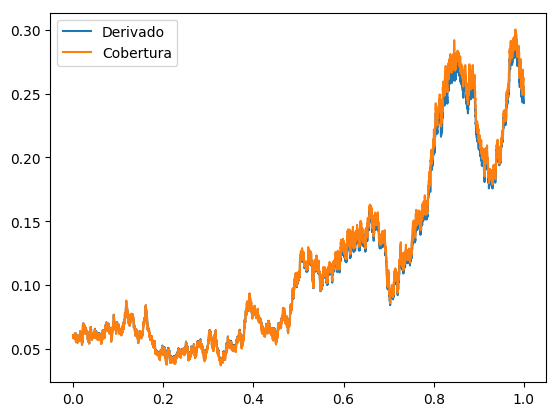

In [12]:
n_rebalanceo = 10000 
TTM = 1

time = np.linspace(0, TTM, n_rebalanceo + 1,True)

delta_t = TTM / n_rebalanceo

# Definimos la fórmula que nos da Delta:
def BS_delta(Spot, K, TTM, r, vol, q):
    d1 = (np.log(Spot / K) + (r - q + 0.5 * vol**2)) / (vol * np.sqrt(TTM))

    return np.exp(-q*TTM)*N(d1)


# Vectores N(0,1)
phi_1 = np.random.normal(0,1,n_rebalanceo + 1)
phi_2 = np.random.normal(0,1,n_rebalanceo + 1)

# Los correlamos y tenemos los dW
dW_S = phi_1 * np.sqrt(delta_t)
dW_X = (rho * phi_1 + np.sqrt(1-rho**2) * phi_2) * np.sqrt(delta_t)

# Valor del derivado
V = np.zeros(n_rebalanceo + 1)
V[0] = BS_call_dividendos(S0, S0, TTM, r_D, vol_S, q) / S0


# Cuenta corriente doméstica
CC_D = np.zeros(n_rebalanceo + 1)
CC_D[0] = V[0]

# alpha
Delta_0 = BS_delta(S0, S0, TTM, r_D, vol_S, q)

alpha = np.zeros(n_rebalanceo + 1)
alpha[0] = Delta_0 / X0

# Subyacente foráneo
Z_F = np.zeros(n_rebalanceo + 1)
Z_F[0] = alpha[0] * S0


# Cuenta corriente foránea
CC_F = np.zeros(n_rebalanceo + 1)
CC_F[0] = -Z_F[0]

# St y Xt
S = np.zeros(n_rebalanceo + 1)
S[0] = S0
X = np.zeros(n_rebalanceo + 1)
X[0] = X0

# Cobertura
H = np.zeros(n_rebalanceo + 1)
H[0] = CC_D[0] + (Z_F[0] + CC_F[0]) * X[0]

for i in range(1, n_rebalanceo + 1):
    
    # S_t
    S[i] = S[i-1] + mu_S_P * S[i-1] * delta_t + vol_S * S[i-1] * dW_S[i]
    
    # X_t
    X[i] = X[i-1] + mu_X_P * X[i-1] * delta_t + vol_X * X[i-1] * dW_X[i]
    
    # CC_D
    CC_D[i] = CC_D[i-1] * (1 + r_D * delta_t)
    
    # alpha_t
    alpha[i] = BS_delta(S[i], S0, (TTM - time[i]) , r_D, vol_S, q) / X[i]
    
    # Z_F
    Z_F[i] = alpha[i] * S[i]
    
    # CC_F
    CC_F[i] = CC_F[i-1] * (1 + r_F * delta_t) - (alpha[i]-alpha[i-1]) * S[i]

    # Cobertura
    H[i] = CC_D[i] + (Z_F[i] + CC_F[i]) * X[i]
    
    # Valor del derivado
    V[i] = BS_call_dividendos(S[i], S0, (TTM - time[i]), r_D, vol_S, q) / S0

# Gráfica
f, ax = plt.subplots()
ax.plot(time, V, label = 'Derivado')  
ax.plot(time, H, label = 'Cobertura')  
ax.legend()